# Links
- http://tdface.ece.tufts.edu/downloads/TD_RGB_E/
- http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html
-> Try the Yale face dataset

# 1.0) data prep - images too large, occupies too much space

In [1]:
import pickle 

import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# # RESIZING 

# pose_img_paths = glob.glob('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/pose/set_*/*/*.jpg')

# CROP_BOX_SZ_POSE = 1600
# h1 = 300
# w1 = 1000
# CROP_BOX_POSE = [h1, h1 + CROP_BOX_SZ_POSE, w1, w1 + CROP_BOX_SZ_POSE]  # h1, h2, w1, w2
# RESIZE_SHAPE = (256, 256)


# def load_img_rsz_and_crop(image_path, crop_box, resize_shape=RESIZE_SHAPE):
#     im = cv2.imread(image_path)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im_cropped = im[
#         crop_box[0]:crop_box[1], crop_box[2]:crop_box[3]
#     ]
#     im_resized = cv2.resize(im_cropped, resize_shape)
#     return im, im_resized

# resized_pose_images = {}
# for ind, im_path in enumerate(pose_img_paths):
#     im, im_resized = load_img_rsz_and_crop(im_path, CROP_BOX_POSE)
#     resized_pose_images[im_path] = im_resized
#     if ind % 100 == 0:
#         print('%d / %d' % (ind, len(pose_img_paths)))

# with open('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/pose_data_resized.pkl', 'wb') as file:
#     pickle.dump(resized_pose_images, file)

    
# def test_single_example_pose():
#     im_path = pose_img_paths[np.random.choice(len(pose_img_paths))]
#     im, im_resized = load_img_rsz_and_crop(im_path, CROP_BOX_POSE)
#     plt.figure(1)
#     plt.imshow(im)

#     plt.figure(2)
#     plt.imshow(im_resized)


# test_single_example_pose()


In [3]:
# import pickle 

# CROP_BOX_SZ_EMOTION = 2300
# h1 = 250
# w1 = 1100
# CROP_BOX_EMOTION = [h1, h1 + CROP_BOX_SZ_EMOTION, w1, w1 + CROP_BOX_SZ_EMOTION]  # h1, h2, w1, w2
# # emotion_img_paths = glob.glob('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/emotions/set_*/*/*.jpg')


# def test_single_example_emotion():
#     im_path = emotion_img_paths[np.random.choice(len(emotion_img_paths))]
#     im, im_resized = load_img_rsz_and_crop(im_path, CROP_BOX_EMOTION)
#     plt.figure(1)
#     plt.imshow(im)

#     plt.figure(2)
#     plt.imshow(im_resized)


# # test_single_example()
    
# resized_emotion_images = {}
# for ind, im_path in enumerate(emotion_img_paths):
#     im, im_resized = load_img_rsz_and_crop(im_path, CROP_BOX_EMOTION)
#     resized_emotion_images[im_path] = im_resized

# with open('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/emotion_data_resized.pkl', 'wb') as file:
#     pickle.dump(resized_emotion_images, file)
    


In [2]:
# load saved data 

with open('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/pose_data_resized.pkl', 'rb') as file:
    resized_pose_images = pickle.load(file)

with open('/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/emotion_data_resized.pkl', 'rb') as file:
    resized_emotion_images = pickle.load(file)

len(resized_pose_images), len(resized_emotion_images)

(3406, 560)

In [3]:
# IMPORTANT CONCEPT - train / test seperation

import copy

emotion_img_paths = list(resized_emotion_images.keys())
emotion_img_paths[0], resized_emotion_images[emotion_img_paths[0]]

train_sets = ['set_1', 'set_2', 'set_3']
test_sets = ['set_4']

def generate_paired_data(sets, image_paths_and_array, target_total_pairs=2000):
    # organize images by subjects
    # randomly select 1 subject
    # for 1 positive example, sample 1 negative
    # for selected subject, get an example -> select another from same set -> positive
    # get another example from another subject -> negative
    # record index of positive examples, index of negative examples -> as long as not the same pair, okay
    
    # organize by subject
    image_by_subjects = {}
    subjects_all = set()
    for img_path, img in image_paths_and_array.items():
        img_set = img_path.split('/')[-3]
        if img_set not in sets:
            continue
        subject = img_path.split('/')[-2]
        subjects_all.add(subject)
        image_by_subjects.setdefault(subject, []).append(img)
    
    subjects_all = list(subjects_all)
    
    pairs_count = 0
    used_pairs = set()
    
    def check_not_used(new_pair):
        if new_pair in used_pairs:
            return False
        if (new_pair[1], new_pair[0]) in used_pairs:
            return False
        return True
    
    def check_not_same(pair):
        return pair[0] != pair[1]
    
    
    positive_pairs_all = []
    negative_pairs_all = []
    
    while pairs_count < target_total_pairs:
        rand_subject = subjects_all[np.random.choice(len(subjects_all))]
        other_subjects = set(subjects_all).difference(set(rand_subject))        
        assert not other_subjects.intersection(set(rand_subject))

        other_subject_one = list(other_subjects)[np.random.choice(len(other_subjects))]
        rand_subject_i, rand_subject_j = np.random.choice(
            len(image_by_subjects[rand_subject]), 2, replace=False
        )
        other_subject_j = np.random.choice(len(image_by_subjects[other_subject_one]))
        
        positive_pair = (rand_subject_i, rand_subject_j)
        negative_pair = (rand_subject_i, other_subject_j)
        
        if check_not_used(positive_pair) and check_not_used(negative_pair) and check_not_same(positive_pair):
            positive_pairs_all.append(
                (
                    image_by_subjects[rand_subject][rand_subject_i],
                    image_by_subjects[rand_subject][rand_subject_j],
                )
            )
            negative_pairs_all.append(
                (
                    image_by_subjects[rand_subject][rand_subject_i],
                    image_by_subjects[other_subject_one][other_subject_j],
                )
            )
            
            pairs_count += 1
    
    return positive_pairs_all, negative_pairs_all


pose_and_emotion_images = copy.copy(resized_pose_images)
pose_and_emotion_images.update(resized_emotion_images)

# emotion pairs
train_match_pairs_emo, train_no_match_pairs_emo = (
    generate_paired_data(train_sets, resized_emotion_images, target_total_pairs=1500)
)
test_match_pairs_emo, test_no_match_pairs_emo = (
    generate_paired_data(test_sets, resized_emotion_images, target_total_pairs=200)
)

# # pose pairs
# train_match_pairs_pose, train_no_match_pairs_pose = (
#     generate_paired_data(train_sets, resized_pose_images, target_total_pairs=3000)
# )
# test_match_pairs_pose, test_no_match_pairs_pose = (
#     generate_paired_data(test_sets, resized_pose_images, target_total_pairs=1000)
# )

# train_match_pairs.extend(train_match_pairs_pose)
# train_no_match_pairs.extend(train_no_match_pairs_pose)

# test_match_pairs.extend(test_match_pairs_pose)
# test_no_match_pairs.extend(test_no_match_pairs_pose)


# combined_pairs
train_match_pairs, train_no_match_pairs = (
    generate_paired_data(train_sets, pose_and_emotion_images, target_total_pairs=5500)
)
test_match_pairs, test_no_match_pairs = (
    generate_paired_data(test_sets, pose_and_emotion_images, target_total_pairs=1800)
)

train_match_pairs.extend(train_match_pairs_emo)
train_no_match_pairs.extend(train_no_match_pairs_emo)
test_match_pairs.extend(test_match_pairs_emo)
test_no_match_pairs.extend(test_no_match_pairs_emo)

len(train_match_pairs), len(train_no_match_pairs), len(test_match_pairs), len(test_no_match_pairs)


(7000, 7000, 2000, 2000)

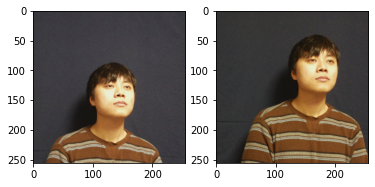

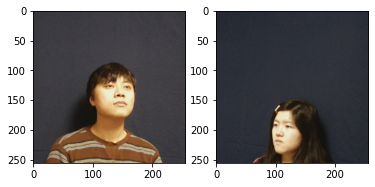

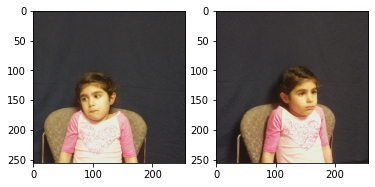

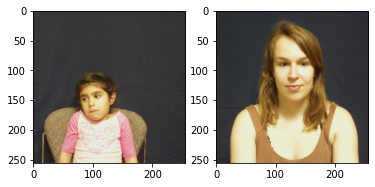

In [4]:
# CONCEPT - always visualize what your data looks like

example_ind = np.random.choice(len(train_match_pairs))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(train_match_pairs[example_ind][0])
axes[1].imshow(train_match_pairs[example_ind][1])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(train_no_match_pairs[example_ind][0])
axes[1].imshow(train_no_match_pairs[example_ind][1])

example_ind = np.random.choice(len(test_match_pairs))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_match_pairs[example_ind][0])
axes[1].imshow(test_match_pairs[example_ind][1])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_no_match_pairs[example_ind][0])
axes[1].imshow(test_no_match_pairs[example_ind][1])


1.0
1.0


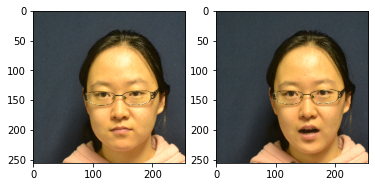

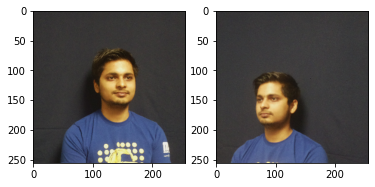

In [5]:
# now vectorize into form easy to train networks

# X_train_a = np.concatenate(
#     (
#         np.array([pair[0] for pair in train_match_pairs]), 
#         np.array([pair[0] for pair in train_no_match_pairs ])
#     )
# ).astype('float32') / 255

# X_train_b = np.concatenate(
#     (
#         np.array([pair[1] for pair in train_match_pairs]), 
#         np.array([pair[1] for pair in train_no_match_pairs])
#     )
# ).astype('float32') / 255

# y_train = np.array(
#     [1] * len(train_match_pairs) + 
#     [0] * len(train_no_match_pairs)
# ).astype('float32')


# X_test_a = np.concatenate(
#     (
#         np.array([pair[0] for pair in test_match_pairs]), 
#         np.array([pair[0] for pair in test_no_match_pairs])
#     )
# ).astype('float32') / 255

# X_test_b = np.concatenate(
#     (
#         np.array([pair[1] for pair in test_match_pairs]), 
#         np.array([pair[1] for pair in test_no_match_pairs])
#     )
# ).astype('float32') / 255

# y_test = np.array(
#     [1] * len(test_match_pairs) + 
#     [0] * len(test_no_match_pairs)
# ).astype('float32')


ind = np.random.choice(len(X_train_a))
print(y_train[ind])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_train_a[ind])
axes[1].imshow(X_train_b[ind])

ind = np.random.choice(len(X_test_a))
print(y_test[ind])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_test_a[ind])
axes[1].imshow(X_test_b[ind])


In [6]:
# CONCEPTS - contrastive loss, embedding and distance, siamese network

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Activation,
    Input, Lambda, Dense, 
    Dropout, Conv2D, MaxPooling2D, 
    Flatten, GlobalAveragePooling2D
)

from tensorflow.keras.models import (
    Sequential,
    Model
)

from SiameseFunctions import (
    euclidean_distance,
    eucl_dist_output_shape,
    contrastive_loss,
    compute_accuracy,
    accuracy,
)

from tensorflow.keras.optimizers import RMSprop, Adam

In [37]:
from sklearn.metrics import roc_curve, auc, f1_score

NET_SIZE = X_train_a.shape[1]

def create_base_network(input_d):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    nb_filters = [16, 32, 8]
    kern_size = (3, 3)

    # conv layers
    seq.add(Conv2D(
        nb_filters[0], kern_size, input_shape=input_d)
    )
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  # downsample
#     seq.add(Dropout(.2))
    
    # conv layer 2
    seq.add(Conv2D(nb_filters[1], kern_size))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  # downsample
#     seq.add(Dropout(.2))

    # whittle down
    seq.add(Conv2D(nb_filters[2], kern_size))
    seq.add(Activation('relu'))
#     seq.add(Dropout(.2))
    
    # dense layers
    seq.add(Flatten())
    seq.add(Dense(64, activation='relu'))
#     seq.add(Dropout(0.1))
    seq.add(Dense(16, activation='relu'))
    return seq


input_dim = (NET_SIZE, NET_SIZE, 3)

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)
base_network = create_base_network(input_dim)
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# set up the distance metric
distance = Lambda(
    euclidean_distance, 
    output_shape=eucl_dist_output_shape
)([processed_a, processed_b])

 
# training set up
model = Model(inputs=[input_a, input_b], outputs=[distance])

model_out_path_custom = '/blnas/scratch/nripesh/winter_ai_2021_materials/face_match_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_out_path_custom,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    restore_best_weights=True,
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 16)           1851704     ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [38]:
# CONCEPT: data generators 
from keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 8

data_aug = True


if data_aug:
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.75, 1.25],
    )
else:
    train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

def gen_train_flow():
    train_iterator_a = train_generator.flow(
        X_train_a, 
        y_train, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    train_iterator_b = train_generator.flow(
        X_train_a, 
        X_train_b, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    while True:
        X_a = train_iterator_a.next()
        X_b = train_iterator_b.next()
        yield [X_a[0] / 255, X_b[1]], X_a[1]
        
        
def gen_val_flow():
    test_iterator_a = val_generator.flow(
        X_test_a, 
        y_test, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    test_iterator_b = val_generator.flow(
        X_test_a,
        X_test_b, 
        batch_size=BATCH_SIZE,
        seed=42,
    )
    while True:
        X_a = test_iterator_a.next()
        X_b = test_iterator_b.next()
        yield [X_a[0], X_b[1]], X_a[1]



1.0 1.0
0
1.0


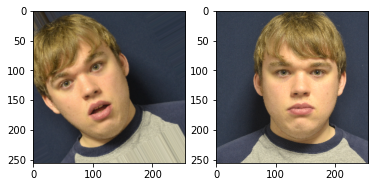

In [39]:
count = 0
for x_ab, yi in gen_train_flow():
    if count == 3:
        break
    count += 1
    rand_ind = np.random.choice(BATCH_SIZE)

print(x_ab[0].max(), x_ab[1].max())
    
fig, axes = plt.subplots(1, 2)
print(rand_ind)
print(yi[rand_ind])
axes[0].imshow(x_ab[0][rand_ind])
axes[1].imshow(x_ab[1][rand_ind])


1.0 1.0
0
0.0


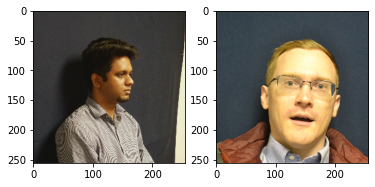

In [40]:
count = 0
for x_ab, yi in gen_val_flow():
    if count == 5:
        break
    count += 1
    rand_ind = np.random.choice(BATCH_SIZE)

print(x_ab[0].max(), x_ab[1].max())
    
fig, axes = plt.subplots(1, 2)
print(rand_ind)
print(yi[rand_ind])
axes[0].imshow(x_ab[0][rand_ind])
axes[1].imshow(x_ab[1][rand_ind])


In [ ]:
# TRAINING

# with augmentation - 
# without augmentation -  

def plot_history(hist):
    """
    Quick function to plot the history 
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(hist.history['loss'], 'r.-')
    axes[0].plot(hist.history['val_loss'], 'b.-')
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_title('losses')
    axes[0].legend(['train_loss', 'val_loss'])
    
    axes[1].plot(hist.history['accuracy'], 'r.-')
    axes[1].plot(hist.history['val_accuracy'], 'b.-')
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_title('accuracies')
    axes[1].legend(['train_accuracy', 'val_accuracy'])
    

steps_per_epoch = int(len(X_train_a) / BATCH_SIZE)
validation_steps = int(len(X_test_a) / BATCH_SIZE)
nb_epochs = 10

model.compile(
    loss=contrastive_loss, 
    optimizer=Adam(),
    metrics=[accuracy]
)

hist = model.fit(
    gen_train_flow(),
    epochs=nb_epochs,
    validation_data=gen_val_flow(),
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback],
)

# model = tf.keras.models.load_model(model_out_path_custom)

plot_history(hist)

Epoch 1/10
1750/1750 [==============================] - 550s 314ms/step - loss: 0.2286 - accuracy: 0.6564 - val_loss: 0.2315 - val_accuracy: 0.6500
Epoch 2/10
1750/1750 [==============================] - 545s 312ms/step - loss: 0.1990 - accuracy: 0.7046 - val_loss: 0.2119 - val_accuracy: 0.6745
Epoch 3/10
1750/1750 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.7206

1.0 [0.10131309] [ True]


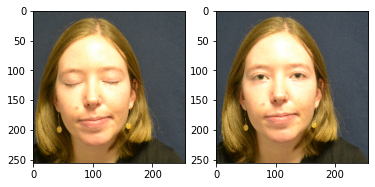

In [190]:
# example on validation data

rand_ind_j = np.random.choice(len(X_test_a))
test_example_a = np.expand_dims(X_test_a[rand_ind_j], 0)
test_example_b = np.expand_dims(X_test_b[rand_ind_j], 0)

test_pred_example_y = model.predict((test_example_a, test_example_b))[0]

print(y_test[rand_ind_j], test_pred_example_y, test_pred_example_y < 0.5)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_example_a[0])
axes[1].imshow(test_example_b[0])

In [27]:
# try mobilenet model with some extra layers

# mobilenet-v3 

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# input and pre-processing
input_dim = (256, 256, 3)

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

input_a_processed = preprocess_input(input_a)
input_b_processed = preprocess_input(input_b)

# base mobilenet model
base_model = MobileNetV3Small(include_top=False, weights='imagenet')
processed_a = base_model(input_a_processed)
processed_b = base_model(input_b_processed)

# add few dense layers
flatten = Flatten()
flattened_a = flatten(processed_a)
flattened_b = flatten(processed_b)
# dense 1
dense_layer_1 = Dense(32, activation='relu')
dense_1_a = dense_layer_1(flattened_a)
dense_1_b = dense_layer_1(flattened_b)
# dense 2
dense_layer_2 = Dense(32, activation='relu')
processed_a = dense_layer_2(dense_1_a)
processed_b = dense_layer_2(dense_1_b)

# set up the distance metric
distance = Lambda(
    euclidean_distance, 
    output_shape=eucl_dist_output_shape
)([processed_a, processed_b])

 
# training set up
mblnet_model = Model(inputs=[input_a, input_b], outputs=[distance])

model_out_path_mblnet = '/blnas/scratch/nripesh/winter_ai_2021_materials/face_match_model_mblnet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_out_path_mblnet,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    restore_best_weights=True,
)

# freeze trainable layer
mblnet_model.layers[2].trainable = False
mblnet_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
MobilenetV3small (Functional)   (None, None, None, 1 1529968     input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 65536)        0           MobilenetV3small[0][0]     

In [26]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [71]:
# TRAINING

steps_per_epoch = int(len(X_train_a) / BATCH_SIZE)
validation_steps = int(len(X_test_a) / BATCH_SIZE)
nb_epochs = 5

mblnet_model.compile(
    loss=contrastive_loss, 
    optimizer=Adam(),
    metrics=[accuracy]
)

hist = mblnet_model.fit(
    gen_train_flow(),
    epochs=nb_epochs,
    validation_data=gen_val_flow(),
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback],
)

# mblnet_model = tf.keras.models.load_model(model_out_path_mblnet)

plot_history(hist)

[[0.25991583]] [[ True]]


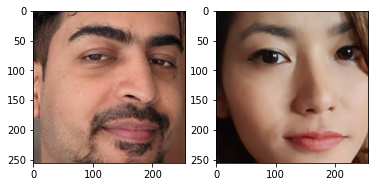

In [98]:
# test with external

model_to_use = 'custom'
# model_to_use = 'mobilenetv3'


if model_to_use == 'custom':
    test_model = model
elif model_to_use == 'mobilenetv3':
    test_model = mblnet_model


def get_background_img():
    return np.zeros((256, 256, 3)).astype('float32') + 0.179

def add_background(img):
    if img.shape[0] >= 256:
        return img
    else:
        x1 = int((256 - img.shape[0]) / 2)
        img_new = get_background_img()
        img_new[x1: x1 + img.shape[0], x1: x1 + img.shape[0]] = img
        return img_new
        

def load_test_images():
    im_by_subjects = {}
    for img_path in glob.glob(
            '/blnas/scratch/nripesh/winter_ai_2021_materials/tufts_data/external_test_set/*.jpg'
    ):
        im = cv2.imread(img_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_resized = cv2.resize(im, (256, 256)).astype('float32') / 255
        img_w_bgnd = add_background(im_resized)
        subject = img_path.split('/')[-1].split('.jpg')[0][:-1]
        im_by_subjects.setdefault(subject, []).append(img_w_bgnd)
    return im_by_subjects


# test_images = load_test_images()

test_subjects = list(test_images.keys())

subject_1 = test_subjects[np.random.choice(len(test_subjects))]
subject_2 = test_subjects[np.random.choice(len(test_subjects))]
# subject_2 = subject_1

ind_i = np.random.choice(2)
ind_j = np.random.choice(2)

test_example_a = np.expand_dims(test_images[subject_1][ind_i], 0)
test_example_b = np.expand_dims(test_images[subject_2][ind_j], 0)

test_example_y = test_model.predict((test_example_a, test_example_b))

print(test_example_y, test_example_y < 0.5)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_example_a[0])
axes[1].imshow(test_example_b[0])